In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, jacrev, grad, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid
from jax.experimental.ode import odeint

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(1)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ind6shiv because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


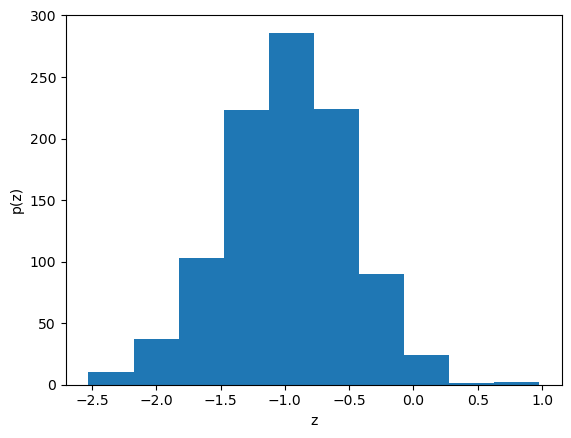

In [2]:
# define mean and stdv of target Gaussian
mean = -1. 
stdv = .5
y = np.random.randn(1000)
z = mean + stdv*y

plt.hist(z)
plt.xlabel('z')
plt.ylabel('p(z)')
plt.show()

In [3]:
# goal is to use a neural network to map Gaussian noise to samples from bimodal distribution

In [4]:
# problem dimension
d = 1

# neural net dimension
h = 4

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[h, d+1], [h], [d, h], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 1./np.sqrt(shape[-1])
    lmbda[k1:k2] = stdv*np.random.randn(k2-k1,)

# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn_int_z(y, t, lmbda):
    
    # weights and biases of nn
    W1, b1, W3, b3 = reshape(lmbda)
    
    # hidden layer
    h = jnp.sin(jnp.einsum('ij,...j->...i', W1, jnp.append(y, t)) + b1)
    
    # hidden layer
    # h = tanh(jnp.einsum('ij,...j->...i', W2, h) + b2)
    
    # output
    dz_dt = jnp.einsum('ij,...j->...i', W3, h) + b3
    
    return dz_dt

# Jacobian of nn_int 
jac_nn_int = jit(jacfwd(nn_int_z))

@jit
def nn_int(aug_y, t, lmbda):
    
    # unpack augmented y
    y, log_pz = aug_y
    
    # dz_dt 
    dz_dt = nn_int_z(y, t, lmbda)
    
    # log likelihood of z_t
    dlog_pz_dt = -jnp.trace(jac_nn_int(y, t, lmbda))
    
    return dz_dt, dlog_pz_dt

# log likelihood of standard Gaussian
@jit 
def log_py(y):
    return -jnp.dot(y, y)/2. - len(y)/2 * jnp.log(2.*np.pi)

@jit
def T(y, lmbda):
    
    # initial condition for log_py
    log_py0 = log_py(y)
    
    # integrate NN and log likelihood of z_t
    z, log_pz = odeint(nn_int, (y, log_py0), jnp.array([0., 1.]), lmbda)

    return z[-1], log_pz[-1]

@jit
def Tz(y, lmbda):
    
    # integrate NN and log likelihood of z_t
    z = odeint(nn_int_z, y, jnp.array([0., 1.]), lmbda)

    return z[-1]
batch_T = vmap(Tz, (0, None))

# gradient of T 
grad_T = jit(jacrev(T, 1))

In [5]:
# nll of true posterior
@jit 
def neg_log_likelihood(zi):
    l1 = 1. / (2.*stdv**2) * (zi - mean)**2. + jnp.log(2.*jnp.pi*stdv**2) / 2.
    return l1[0]
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=100):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    
    # evaluate model fitness 
    KL = 0.
    for yi in y:
        # transform yi and compute log_p(zt)
        zi, log_pzi = T(yi, lmbda)
        
        # divergence btw true posterior
        KL += neg_log_likelihood(zi) / n_sample
        
        # entropy
        KL += log_pzi / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=100):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    
    grad_KL = 0.
    for yi in y:
        # forward pass
        zi, log_pzi = T(yi, lmbda)
        
        # backward pass
        grad_zi, grad_log_pzi = grad_T(yi, lmbda)
        grad_KL += np.einsum('i,ij->j', grad_neg_log_likelihood(zi), grad_zi) / n_sample
        grad_KL += grad_log_pzi / n_sample
        
    return grad_KL

In [6]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=1000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("KL {:.3f}".format(f(params, n_sample=100)))

        gradient = grad_f(params)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [7]:
lmbda = adam_optimizer(kl, grad_kl, lmbda)

KL 5.026
KL 4.153
KL 1.947
KL 0.922
KL 0.457
KL 0.139
KL 0.122
KL 0.031
KL 0.024
KL 0.027
KL 0.074
KL 0.006
KL -0.007
KL 0.021
KL 0.041
KL 0.005
KL 0.025
KL -0.009
KL 0.015
KL 0.005
KL 0.001
KL 0.014
KL 0.050
KL 0.028
KL 0.007
KL -0.001
KL 0.007
KL 0.019
KL 0.024
KL 0.021
KL 0.007
KL 0.022
KL -0.014
KL -0.004
KL -0.005
KL -0.012
KL -0.001
KL 0.018
KL 0.008
KL -0.000
KL 0.008
KL 0.009
KL 0.001
KL 0.004
KL 0.007
KL 0.004
KL -0.009
KL 0.003
KL 0.029
KL -0.012
KL -0.002
KL 0.012
KL 0.001
KL 0.006
KL -0.009
KL 0.005
KL -0.000
KL 0.006
KL -0.006
KL 0.002
KL 0.001
KL 0.006
KL 0.002
KL 0.004
KL 0.018
KL 0.010
KL -0.011
KL 0.005
KL -0.005
KL -0.007
KL -0.001
KL 0.019
KL -0.003
KL -0.006
KL -0.007
KL -0.001
KL -0.000
KL 0.025
KL -0.009
KL 0.002
KL -0.015
KL 0.028
KL -0.003
KL -0.003
KL -0.006
KL -0.003
KL 0.006
KL 0.000
KL 0.020
KL 0.001
KL 0.003
KL -0.000
KL 0.018
KL 0.010
KL 0.009
KL -0.005
KL 0.007
KL 0.014
KL 0.017
KL -0.005


In [8]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(1000, d)
z = batch_T(y, lmbda)

In [9]:
z = np.array(z.ravel())

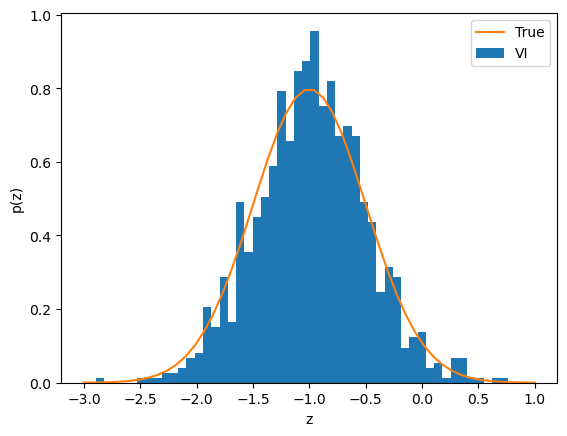

In [12]:
# Calculate the corresponding probability density function (PDF) values
x_vals = np.linspace(-3, 1)
pdf_values = norm.pdf(x_vals, mean, stdv)
plt.plot(x_vals, pdf_values, c='C1', label='True')
plt.hist(z, bins=50, density=True, label="VI")
plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend()
plt.show()